### Set-Up

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scienceplots

import statsmodels.tsa.api as tsa

from scipy.linalg import cholesky
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

# Plot Setting
plt.style.use("science")

### Transform data

In [2]:
mydata = pd.read_csv("mydata.csv")
mydata["time"] = pd.to_datetime(mydata["time"]).dt.to_period("Q")
mydata.set_index("time", inplace=True)
mydata.head()

C:\Users\Yutao\AppData\Local\Temp\ipykernel_10480\1026011974.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mydata["time"] = pd.to_datetime(mydata["time"]).dt.to_period("Q")


,Interest Rate,Real Wages,Adjusted Reserves,PPIC,GDP,private_consumption,government_expenditure,government_revenue,private_non_residential_investment,gdp_deflator,Population
time,,,,,,,,,,,
1954Q3,1.03,42.832,8.191,31.4,390996000000,240303000000,91148000000,8.474900e+10,36788000000,13.574,162731000.0
1954Q4,0.99,43.388,8.362,31.1,399734000000,245093000000,91356000000,8.722100e+10,38574000000,13.611,163524000.0
1955Q1,1.34,43.629,8.339,30.9,413073000000,251398000000,91869000000,9.190400e+10,43283000000,13.675,164204000.0
1955Q2,1.50,44.054,8.358,30.6,421532000000,256466000000,92533000000,9.433300e+10,46683000000,13.731,164864000.0
1955Q3,1.94,44.802,8.320,30.3,430221000000,260651000000,94099000000,9.668100e+10,49121000000,13.827,165612000.0


In [3]:
denominator = mydata["gdp_deflator"] * mydata["Population"]
print(denominator.head())
names = [
    "GDP",
    "private_consumption",
    "government_expenditure",
    "government_revenue",
    "private_non_residential_investment",
]
for name in names:
    mydata[f"real_{name}"] = mydata[name] / denominator
mydata.iloc[:, 1:] = mydata.iloc[:, 1:].map(lambda x: np.log(x))
mydata.head()

time
1954Q3    2.208911e+09
1954Q4    2.225725e+09
1955Q1    2.245490e+09
1955Q2    2.263748e+09
1955Q3    2.289917e+09
Freq: Q-DEC, dtype: float64


C:\Users\Yutao\AppData\Local\Temp\ipykernel_10480\1810958852.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'time
1954Q3    26.691963
1954Q4    26.714065
1955Q1    26.746890
1955Q2    26.767162
1955Q3    26.787565
            ...    
2014Q4    30.516496
2015Q1    30.524916
2015Q2    30.536817
2015Q3    30.543460
2015Q4    30.545280
Freq: Q-DEC, Name: GDP, Length: 246, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mydata.iloc[:, 1:] = mydata.iloc[:, 1:].map(lambda x: np.log(x))
C:\Users\Yutao\AppData\Local\Temp\ipykernel_10480\1810958852.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'time
1954Q3    26.205166
1954Q4    26.224904
1955Q1    26.250303
1955Q2    26.270262
1955Q3    26.286448
            ...    
2014Q4    30.122702
2015Q1    30.125859
2015Q2    30.137701
2015Q3    3

,Interest Rate,Real Wages,Adjusted Reserves,PPIC,GDP,private_consumption,government_expenditure,government_revenue,private_non_residential_investment,gdp_deflator,Population,real_GDP,real_private_consumption,real_government_expenditure,real_government_revenue,real_private_non_residential_investment
time,,,,,,,,,,,,,,,,
1954Q3,1.03,3.757285,2.103036,3.446808,26.691963,26.205166,25.235750,25.162960,24.328438,2.608156,18.907609,5.176198,4.689401,3.719985,3.647194,2.812672
1954Q4,0.99,3.770183,2.123698,3.437208,26.714065,26.224904,25.238030,25.191711,24.375844,2.610878,18.912470,5.190717,4.701555,3.714681,3.668362,2.852496
1955Q1,1.34,3.775722,2.120943,3.430756,26.746890,26.250303,25.243629,25.244010,24.491026,2.615569,18.916620,5.214701,4.718114,3.711440,3.711821,2.958836
1955Q2,1.50,3.785416,2.123219,3.421000,26.767162,26.270262,25.250831,25.270097,24.566646,2.619656,18.920631,5.226874,4.729974,3.710544,3.729809,3.026358
1955Q3,1.94,3.802253,2.118662,3.411148,26.787565,26.286448,25.267613,25.294683,24.617552,2.626623,18.925158,5.235783,4.734667,3.715832,3.742901,3.065771


In [4]:
filter_data = mydata[(mydata.index >= "1955Q1") & (mydata.index <= "2000Q4")]
filter_data.head()

,Interest Rate,Real Wages,Adjusted Reserves,PPIC,GDP,private_consumption,government_expenditure,government_revenue,private_non_residential_investment,gdp_deflator,Population,real_GDP,real_private_consumption,real_government_expenditure,real_government_revenue,real_private_non_residential_investment
time,,,,,,,,,,,,,,,,
1955Q1,1.34,3.775722,2.120943,3.430756,26.746890,26.250303,25.243629,25.244010,24.491026,2.615569,18.916620,5.214701,4.718114,3.711440,3.711821,2.958836
1955Q2,1.50,3.785416,2.123219,3.421000,26.767162,26.270262,25.250831,25.270097,24.566646,2.619656,18.920631,5.226874,4.729974,3.710544,3.729809,3.026358
1955Q3,1.94,3.802253,2.118662,3.411148,26.787565,26.286448,25.267613,25.294683,24.617552,2.626623,18.925158,5.235783,4.734667,3.715832,3.742901,3.065771
1955Q4,2.36,3.808261,2.119743,3.394508,26.803410,26.301632,25.259418,25.318567,24.718103,2.636483,18.930019,5.236908,4.735131,3.692916,3.752066,3.151601
1956Q1,2.48,3.823585,2.124893,3.391147,26.809463,26.307348,25.275541,25.331651,24.715412,2.646458,18.934157,5.228848,4.726733,3.694926,3.751036,3.134796


### VAR Estimation

In [5]:
names = [
    "real_GDP",
    "real_private_consumption",
    "real_government_expenditure",
    "real_government_revenue",
    "Real Wages",
    "real_private_non_residential_investment",
    "Interest Rate",
    "Adjusted Reserves",
    "PPIC",
    "gdp_deflator",
]
X = filter_data[names]
X.to_csv(
    r"D:\Program Files (x86)\Project\PythonProject\Python Time Series\Replicate\X_clean.csv"
)

In [6]:
var_res = tsa.VAR(X).fit(6, trend="n")
print(var_res.params)

                                            real_GDP  \
L1.real_GDP                                 1.305547   
L1.real_private_consumption                -0.019782   
L1.real_government_expenditure             -0.118526   
L1.real_government_revenue                 -0.015498   
L1.Real Wages                               0.088694   
L1.real_private_non_residential_investment -0.033629   
L1.Interest Rate                            0.000240   
L1.Adjusted Reserves                       -0.042951   
L1.PPIC                                     0.017154   
L1.gdp_deflator                             0.494562   
L2.real_GDP                                 0.031544   
L2.real_private_consumption                -0.086710   
L2.real_government_expenditure              0.076327   
L2.real_government_revenue                 -0.011402   
L2.Real Wages                              -0.214268   
L2.real_private_non_residential_investment -0.001284   
L2.Interest Rate                           -0.00

#### Get Parameter

In [ ]:
sigma = var_res.sigma_u
params = var_res.params
B0 = cholesky(sigma, lower=True)
dim = B0.shape[0]

EigResult(eigenvalues=array([6.05540084e-01, 2.17083871e-03, 9.91441206e-04, 5.09016222e-04,
       2.33565642e-04, 1.13006627e-04, 4.22127955e-05, 2.75932857e-05,
       4.50949418e-06, 5.16867441e-06]), eigenvectors=array([[ 1.56696610e-03, -1.32638996e-01, -2.91734343e-02,
         1.81941550e-02, -1.72165953e-01, -2.58804974e-01,
         4.48254430e-01, -1.98589102e-01, -5.92819341e-01,
         5.41106975e-01],
       [ 1.75783431e-03, -2.33332913e-02, -2.90147175e-02,
         4.21859671e-02, -1.73340986e-01, -1.35175697e-01,
         7.25406987e-01, -3.01802630e-01,  4.86999048e-01,
        -3.06664627e-01],
       [-9.38264558e-04, -1.03783384e-02,  1.10796384e-02,
        -5.77581859e-02, -1.90175468e-01, -9.17447407e-01,
        -2.83482260e-01,  1.21512946e-01,  1.35199719e-01,
        -7.17609822e-02],
       [ 7.54888128e-03, -2.10511542e-01, -8.52818989e-02,
         4.32843492e-02, -9.13700744e-01,  2.56560115e-01,
        -2.08345603e-01, -2.83609136e-03,  4.98647747e-

#### Define f function

In [8]:
def f(x):
    if x >= 0:
        res = 100 * x
    else:
        res = x
    return res

#### Define get_q

In [9]:
def get_q(m):
    random_vector = np.random.randn(m)
    q = random_vector / np.linalg.norm(random_vector)

    return q

#### Define get_r_ja

In [10]:
def get_r_ja(var_res, q, horizon=10):
    q = np.asarray(q)
    n = var_res.neqs

    irf = var_res.irf(horizon)
    orth_irfs = irf.orth_irfs

    r_a = np.zeros((horizon + 1, n))

    for k in range(horizon + 1):
        r_a[k, :] = orth_irfs[k] @ q

    return r_a

#### Test function

In [11]:
q = get_q(10)
irf = var_res.irf(10)
orth_irfs = irf.orth_irfs
r_a_by_func = get_r_ja(var_res=var_res, q=q)
print(orth_irfs[1, :, :] @ q)

[ 8.91738561e-04  2.11450545e-03 -3.05689297e-04  8.43581690e-03
  4.65295570e-04  9.53063511e-03  3.53786036e-01 -1.35729952e-03
  7.45466350e-03 -3.35155945e-04]


In [12]:
print(r_a_by_func[1,])

[ 8.91738561e-04  2.11450545e-03 -3.05689297e-04  8.43581690e-03
  4.65295570e-04  9.53063511e-03  3.53786036e-01 -1.35729952e-03
  7.45466350e-03 -3.35155945e-04]


#### Define psi function

In [13]:
def psi(q, positive, negative, periods):
    positive_part = 0
    negative_part = 0
    if len(positive) > 0:
        for positive_index in positive:
            for period in range(periods + 1):
                std = np.sqrt(np.diag(sigma)[positive_index])
                inner_part = (
                    get_r_ja(var_res, q=q, horizon=10)[period, positive_index] / std
                )
                positive_part += f(-1 * inner_part)

    if len(negative) > 0:
        for negative_index in negative:
            for period in range(periods + 1):
                std = np.sqrt(np.diag(sigma)[negative_index])
                inner_part = (
                    get_r_ja(var_res, q=q, horizon=10)[period, negative_index] / std
                )
                negative_part += f(inner_part)
    res = positive_part + negative_part
    return res

#### Business Cycle shocks

In [14]:
positive = [0, 1, 3, 5]
negative = []
periods = 3


q0 = get_q(10)

norm_constraint = NonlinearConstraint(lambda q: np.sum(q**2), lb=1.0, ub=1.0)

res = minimize(
    fun=lambda q: psi(q, positive, negative, periods),
    x0=q0,
    method="trust-constr",
    constraints=[norm_constraint],
    options={"verbose": 2, "maxiter": 1000, "xtol": 1e-12},
)

q_business_shocks = res.x

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  11   |   0   | +7.0345e+01 | 1.00e+00 | 9.33e+02 | 0.00e+00 |
|   2   |  22   |   1   | -1.3419e+01 | 1.00e+00 | 6.61e+00 | 1.00e+00 |
|   3   |  33   |   2   | -1.0034e+01 | 2.47e+00 | 6.65e+00 | 1.25e-01 |
|   4   |  44   |   3   | -9.5650e+00 | 2.47e+00 | 6.53e+00 | 3.55e-03 |
|   5   |  55   |   4   | -9.6376e+00 | 2.47e+00 | 6.41e+00 | 8.88e-05 |
|   6   |  66   |   5   | -9.7254e+00 | 2.47e+00 | 6.29e+00 | 8.47e-05 |
|   7   |  77   |   6   | -9.8116e+00 | 2.47e+00 | 6.17e+00 | 8.31e-05 |
|   8   |  88   |   7   | -9.8961e+00 | 2.47e+00 | 6.05e+00 | 8.15e-05 |
|   9   |  110  |   8   | -9.8961e+00 | 2.47e-01 | 6.05e+00 | 8.15e-05 |
|  10   |  132  |   9   | -1.1899e+01 | 1.73e+00 | 4.22e+00 | 9.40e-04 |
|  11   |  154  |  10   | -1.2479e+01 | 1.73e+00 | 3.61e+00 | 2.70e-05 |
|  12   |  176  |  11   | -1.3641e+01 | 1.73e+00 | 

d:\Miniforge3\envs\py314\Lib\site-packages\scipy\optimize\_differentiable_functions.py:737: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|  17   |  242  |  17   | -1.3594e+01 | 1.73e+00 | 7.41e-07 | 0.00e+00 |
|  18   |  264  |  22   | -1.3594e+01 | 1.73e-01 | 7.41e-07 | 0.00e+00 |
|  19   |  286  |  27   | -1.3594e+01 | 1.73e-01 | 4.07e-07 | 0.00e+00 |
|  20   |  308  |  35   | -1.3594e+01 | 1.73e-02 | 4.07e-07 | 0.00e+00 |
|  21   |  330  |  43   | -1.3594e+01 | 1.73e-03 | 4.07e-07 | 0.00e+00 |
|  22   |  352  |  52   | -1.3594e+01 | 1.73e-04 | 4.07e-07 | 0.00e+00 |
|  23   |  374  |  59   | -1.3594e+01 | 1.73e-05 | 4.07e-07 | 0.00e+00 |
|  24   |  396  |  67   | -1.3594e+01 | 1.73e-06 | 4.07e-07 | 0.00e+00 |
|  25   |  418  |  74   | -1.3594e+01 | 1.73e-07 | 4.07e-07 | 0.00e+00 |
|  26   |  440  |  82   | -1.3594e+01 | 1.73e-08 | 4.07e-07 | 0.00e+00 |
|  27   |  462  |  87   | -1.3594e+01 | 2.08e-09 | 4.07e-07 | 0.00e+00 |
|  28   |  484  |  90   | -1.3594e+01 | 6.79e-10 | 4.07e-07 | 0.00e+00 |
|  29   |  506  |  92   | -1.3594e+01 | 2.30e-10 | 4.07e-07 | 0.00e+00 |
|  30   |  528  |  94   | -1.3594e+01 | 6.40e-11 | 

In [15]:
r_business = get_r_ja(var_res, q_business_shocks, 25)
print(r_business.shape)

(26, 10)


#### Plot Business shocks

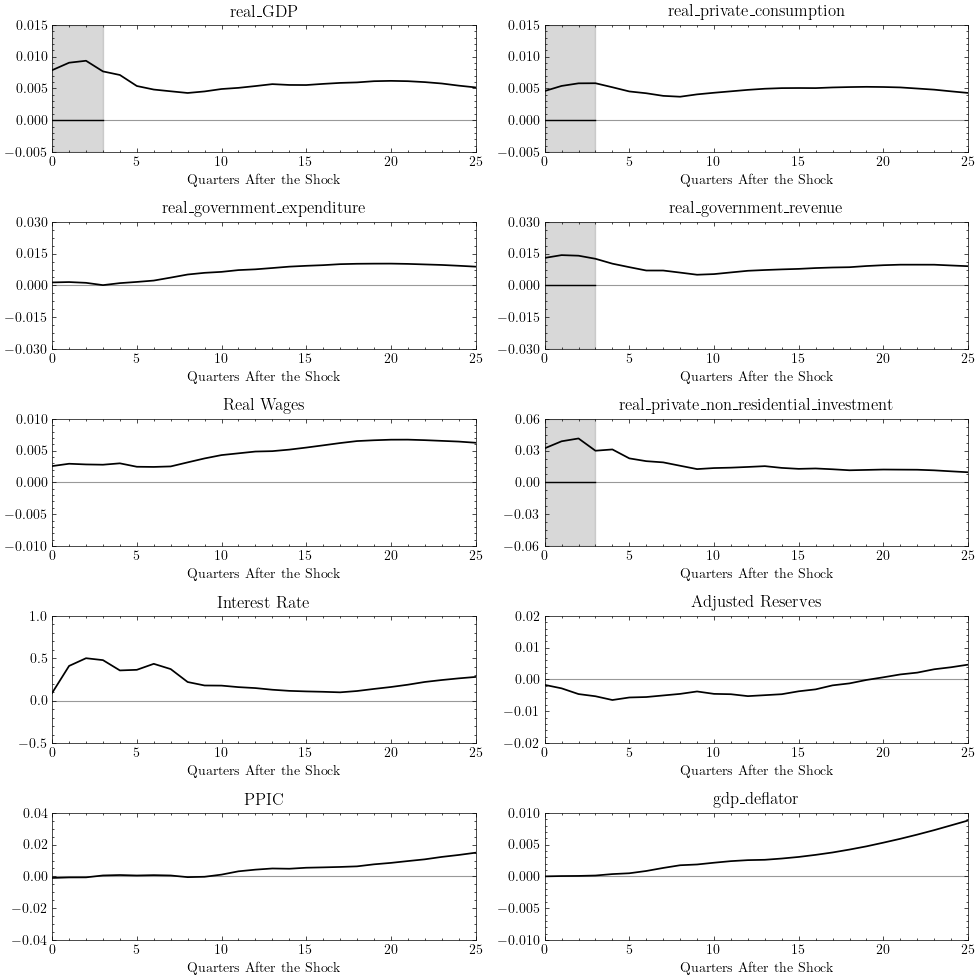

In [16]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_business[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[0, 0].axvspan(0, 3, color="gray", alpha=0.3)
axes[0, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[1, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[2, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[0, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[0, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[2, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.005, 0.015)
axes[0, 1].set_ylim(-0.005, 0.015)
axes[1, 0].set_ylim(-0.03, 0.03)
axes[1, 1].set_ylim(-0.03, 0.03)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.06, 0.06)
axes[3, 0].set_ylim(-0.5, 1)
axes[3, 1].set_ylim(-0.02, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[1, 1].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[2, 1].set_yticks([-0.06, -0.03, 0, 0.03, 0.06])

plt.tight_layout()
plt.savefig("business.pdf", format="PDF")
plt.show()

#### Monetary shocks

In [17]:
positive = [6]
negative = [7, 8, 9]
periods = 3

q0 = get_q(10)

q_business_shocks = q_business_shocks / np.linalg.norm(q_business_shocks)

norm_constraint = NonlinearConstraint(lambda q: np.sum(q**2), lb=1.0, ub=1.0)
orth_constraint = LinearConstraint(q_business_shocks.reshape(1, -1), lb=0.0, ub=0.0)

res = minimize(
    fun=lambda q: psi(q, positive, negative, periods),
    x0=q0,
    method="trust-constr",
    constraints=[norm_constraint, orth_constraint],
    options={"verbose": 2, "maxiter": 1000, "xtol": 1e-12},
)

q_monetary_shocks = res.x

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  11   |   0   | +3.3408e+02 | 1.00e+00 | 4.94e+02 | 2.20e-01 |
|   2   |  22   |   1   | +2.1411e+02 | 1.00e+00 | 2.24e+02 | 1.00e+00 |
|   3   |  33   |   3   | +1.1163e+02 | 2.70e+00 | 2.53e+02 | 1.49e-01 |
|   4   |  44   |   5   | +4.8423e+01 | 2.70e+00 | 2.61e+02 | 3.88e-02 |
|   5   |  55   |   8   | +1.1161e+01 | 2.70e+00 | 2.92e+02 | 3.83e-01 |
|   6   |  66   |  11   | -1.4993e+00 | 2.70e+00 | 9.53e+01 | 3.01e-02 |
|   7   |  77   |  14   | -3.8001e+00 | 2.70e+00 | 9.51e+01 | 7.36e-04 |
|   8   |  88   |  17   | -5.5009e+00 | 2.70e+00 | 4.36e+00 | 4.80e-04 |
|   9   |  99   |  19   | -5.5206e+00 | 2.70e+00 | 4.36e+00 | 1.07e-05 |
|  10   |  110  |  21   | -5.5448e+00 | 2.70e+00 | 4.36e+00 | 1.54e-05 |
|  11   |  121  |  23   | -5.5687e+00 | 2.70e+00 | 4.35e+00 | 1.52e-05 |
|  12   |  132  |  25   | -5.5925e+00 | 2.70e+00 | 

d:\Miniforge3\envs\py314\Lib\site-packages\scipy\optimize\_differentiable_functions.py:737: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|  86   | 1298  |  191  | -8.3926e+00 | 6.87e-09 | 3.23e+01 | 2.04e-13 |
|  87   | 1320  |  192  | -8.3926e+00 | 3.43e-09 | 3.23e+01 | 2.04e-13 |


d:\Miniforge3\envs\py314\Lib\site-packages\scipy\optimize\_differentiable_functions.py:385: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  88   | 1342  |  193  | -8.3926e+00 | 1.72e-09 | 3.23e+01 | 2.04e-13 |
|  89   | 1364  |  194  | -8.3926e+00 | 8.59e-10 | 3.23e+01 | 2.04e-13 |
|  90   | 1386  |  195  | -8.3926e+00 | 4.29e-10 | 3.23e+01 | 2.04e-13 |
|  91   | 1408  |  196  | -8.3926e+00 | 2.15e-10 | 3.23e+01 | 2.04e-13 |
|  92   | 1430  |  197  | -8.3926e+00 | 1.07e-10 | 3.23e+01 | 2.04e-13 |
|  93   | 1452  |  198  | -8.3926e+00 | 5.37e-11 | 3.23e+01 | 2.04e-13 |
|  94   | 1474  |  199  | -8.3926e+00 | 2.68e-11 | 3.23e+01 | 2.04e-13 |
|  95   | 1496  |  200  | -8.3926e+00 | 1.34e-11 | 3.23e+01 | 2.04e-13 |
|  96   | 1518  |  201  | -8.3926e+00 | 6.71e-12 | 3.23e+01 | 2.04e-13 |
|  97   | 1540  |  202  | -8.3926e+00 | 3.35e-12 | 3.23e+01 | 2.04e-13 |
|  98   | 1562  |  203  | -8.3926e+00 | 1.68e-12 | 3.23e+01 | 2.04e-13 |
|  99   | 1584  |  204  | -8.3926e+00 | 8.39e-13 | 3.23e+01 | 2.04e-13 |

`xtol` termination condition is satisfied.
Number of iterations: 99, function evaluations: 1584, CG iterations: 204, optima

In [18]:
r_monetary = get_r_ja(var_res, q_monetary_shocks, 25)
print(r_monetary.shape)

(26, 10)


#### Plot Monetary Shocks

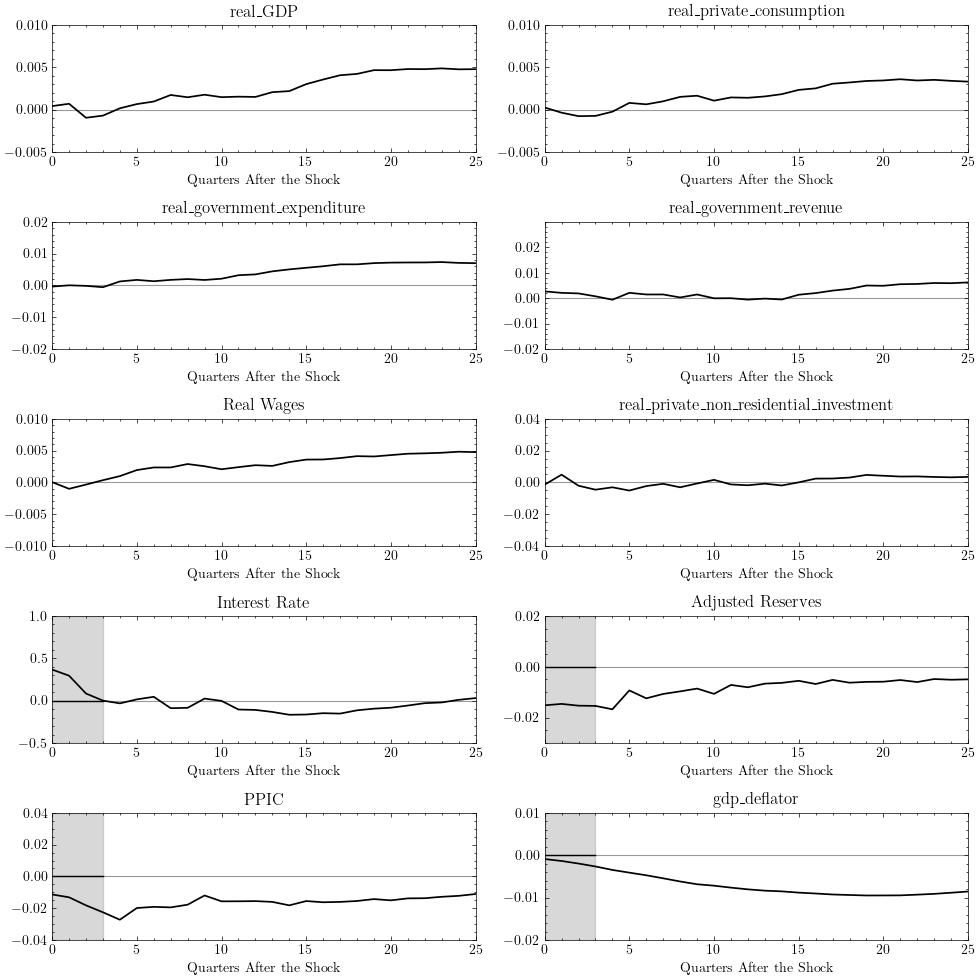

In [19]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_monetary[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[3, 0].axvspan(0, 3, color="gray", alpha=0.3)
axes[3, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[4, 0].axvspan(0, 3, color="gray", alpha=0.3)
axes[4, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[3, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[3, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[4, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[4, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.005, 0.01)
axes[0, 1].set_ylim(-0.005, 0.01)
axes[1, 0].set_ylim(-0.02, 0.02)
axes[1, 1].set_ylim(-0.02, 0.03)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 1)
axes[3, 1].set_ylim(-0.03, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.02, 0.01)

axes[1, 1].set_yticks([-0.02, -0.01, 0, 0.01, 0.02])
plt.tight_layout()
plt.savefig("monetary.pdf", format="PDF")
plt.show()

#### Fiscal revenue shocks

In [20]:
positive = [3]
negative = []
periods = 3

q0 = get_q(10)

q_business_shocks = q_business_shocks / np.linalg.norm(q_business_shocks)
q_monetary_shocks = q_monetary_shocks / np.linalg.norm(q_monetary_shocks)

norm_constraint = NonlinearConstraint(lambda q: np.sum(q**2), lb=1.0, ub=1.0)
orth_constraint1 = LinearConstraint(q_business_shocks.reshape(1, -1), lb=0.0, ub=0.0)
orth_constraint2 = LinearConstraint(q_monetary_shocks.reshape(1, -1), lb=0.0, ub=0.0)


res = minimize(
    fun=lambda q: psi(q, positive, negative, periods),
    x0=q0,
    method="trust-constr",
    constraints=[norm_constraint, orth_constraint1, orth_constraint2],
    options={"verbose": 2, "maxiter": 1000, "xtol": 1e-12},
)

q_revenue_shocks = res.x


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  11   |   0   | -4.1327e-01 | 1.00e+00 | 1.71e+00 | 4.12e-01 |
|   2   |  22   |   1   | -2.1553e+00 | 7.00e+00 | 6.45e-01 | 1.00e+00 |
|   3   |  33   |   2   | -2.1553e+00 | 1.20e+00 | 6.45e-01 | 1.00e+00 |
|   4   |  44   |   3   | -2.9771e+00 | 2.35e+00 | 1.63e-01 | 1.38e+00 |
|   5   |  55   |   4   | -2.1592e+00 | 2.35e+00 | 1.28e-02 | 2.27e-01 |
|   6   |  66   |   5   | -1.9604e+00 | 2.35e+00 | 5.63e-02 | 1.39e-02 |
|   7   |  77   |   6   | -1.9526e+00 | 2.35e+00 | 1.72e-02 | 3.86e-03 |
|   8   |  88   |   7   | -1.9492e+00 | 2.35e+00 | 4.65e-05 | 2.11e-04 |
|   9   |  99   |   8   | -1.9490e+00 | 2.35e+00 | 1.30e-06 | 1.27e-08 |
|  10   |  110  |   9   | -1.9490e+00 | 2.35e+00 | 2.36e-08 | 1.22e-12 |
|  11   |  121  |  11   | -1.9490e+00 | 2.35e+00 | 5.92e-08 | 2.89e-15 |
|  12   |  132  |  12   | -1.9490e+00 | 2.35e+00 | 

d:\Miniforge3\envs\py314\Lib\site-packages\scipy\optimize\_differentiable_functions.py:737: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|  17   |  231  |  23   | -1.9490e+00 | 2.35e-04 | 2.99e-08 | 4.44e-16 |
|  18   |  253  |  27   | -1.9490e+00 | 2.35e-05 | 2.99e-08 | 4.44e-16 |
|  19   |  275  |  30   | -1.9490e+00 | 2.35e-06 | 2.99e-08 | 4.44e-16 |
|  20   |  297  |  35   | -1.9490e+00 | 2.35e-07 | 2.99e-08 | 4.44e-16 |
|  21   |  319  |  42   | -1.9490e+00 | 2.35e-08 | 2.99e-08 | 4.44e-16 |
|  22   |  341  |  44   | -1.9490e+00 | 1.17e-08 | 2.99e-08 | 4.44e-16 |
|  23   |  363  |  45   | -1.9490e+00 | 2.35e-08 | 3.24e-08 | 2.08e-17 |
|  24   |  385  |  47   | -1.9490e+00 | 5.30e-09 | 3.24e-08 | 2.08e-17 |
|  25   |  407  |  48   | -1.9490e+00 | 2.65e-09 | 3.24e-08 | 2.08e-17 |
|  26   |  429  |  50   | -1.9490e+00 | 1.32e-09 | 3.24e-08 | 2.08e-17 |
|  27   |  451  |  52   | -1.9490e+00 | 4.72e-10 | 3.24e-08 | 2.08e-17 |
|  28   |  462  |  55   | -1.9490e+00 | 3.31e-09 | 3.04e-08 | 1.73e-17 |
|  29   |  484  |  58   | -1.9490e+00 | 6.64e-10 | 3.04e-08 | 1.73e-17 |
|  30   |  506  |  60   | -1.9490e+00 | 1.07e-10 | 

In [21]:
r_revenue = get_r_ja(var_res, q_revenue_shocks, 25)
print(r_revenue.shape)

(26, 10)


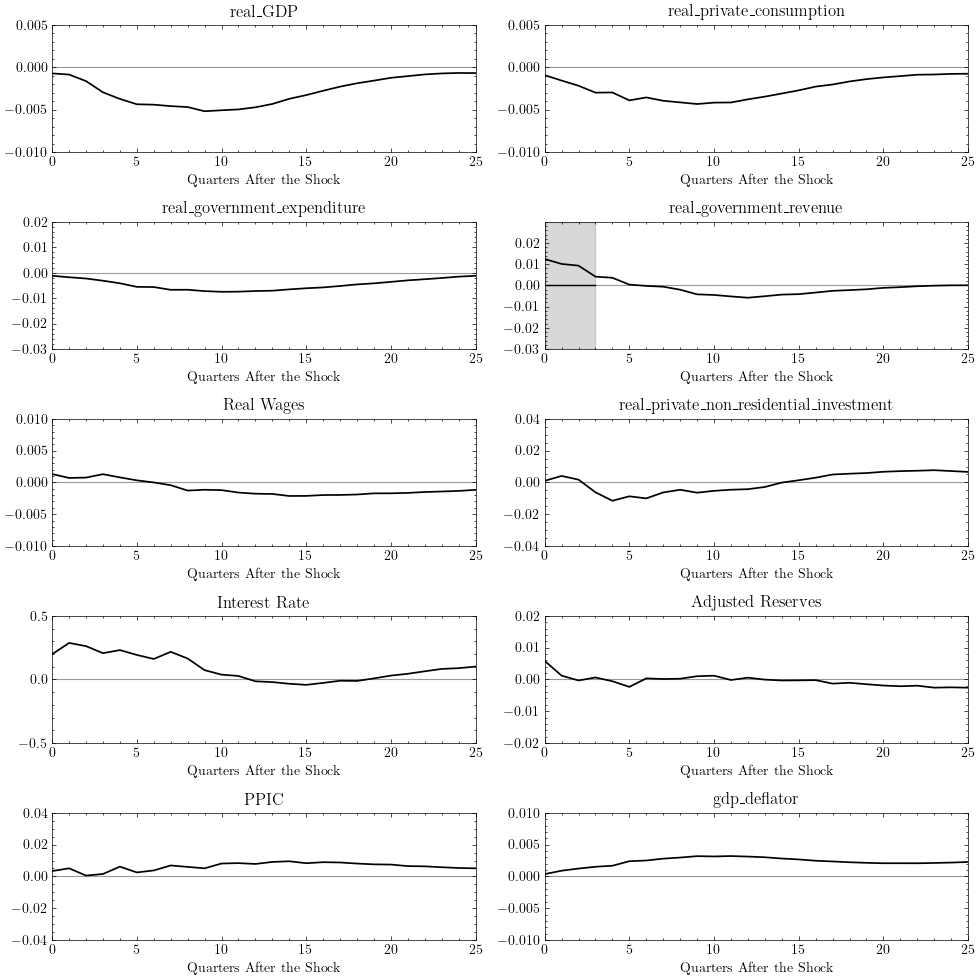

In [22]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_revenue[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[1, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.03)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)


axes[1, 0].set_yticks([-0.03, -0.02, -0.01, 0, 0.01, 0.02])
axes[1, 1].set_yticks([-0.03, -0.02, -0.01, 0, 0.01, 0.02])
axes[3, 0].set_yticks([-0.5, 0, 0.5])

plt.tight_layout()
plt.savefig("revenue.pdf", format="PDF")
plt.show()

#### Fiscal spending shocks

In [23]:
positive = [2]
negative = []
periods = 3


q_business_shocks = q_business_shocks / np.linalg.norm(q_business_shocks)
q_monetary_shocks = q_monetary_shocks / np.linalg.norm(q_monetary_shocks)

norm_constraint = NonlinearConstraint(lambda q: np.sum(q**2), lb=1.0, ub=1.0)
orth_constraint1 = LinearConstraint(q_business_shocks.reshape(1, -1), lb=0.0, ub=0.0)
orth_constraint2 = LinearConstraint(q_monetary_shocks.reshape(1, -1), lb=0.0, ub=0.0)

q0 = get_q(10)

res = minimize(
    fun=lambda q: psi(q, positive, negative, periods),
    x0=q0,
    method="trust-constr",
    constraints=[norm_constraint, orth_constraint1, orth_constraint2],
    options={"verbose": 2, "maxiter": 1000, "xtol": 1e-12},
)

q_spending_shocks = res.x

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  11   |   0   | +1.3716e+02 | 1.00e+00 | 2.48e+02 | 7.33e-03 |
|   2   |  22   |   1   | -1.6334e+00 | 2.00e+00 | 2.71e+00 | 1.00e+00 |
|   3   |  33   |   2   | -9.8452e-01 | 2.53e+00 | 2.84e+00 | 1.31e-01 |
|   4   |  44   |   3   | -9.1420e-01 | 2.53e+00 | 2.85e+00 | 3.81e-03 |
|   5   |  55   |   4   | -9.3201e-01 | 2.53e+00 | 2.84e+00 | 4.14e-05 |
|   6   |  66   |   5   | -9.5253e-01 | 2.53e+00 | 2.83e+00 | 4.19e-05 |
|   7   |  77   |   6   | -9.7293e-01 | 2.53e+00 | 2.82e+00 | 4.15e-05 |
|   8   |  88   |   7   | -9.9320e-01 | 2.53e+00 | 2.81e+00 | 4.12e-05 |
|   9   |  99   |   8   | -1.0133e+00 | 2.53e+00 | 2.79e+00 | 4.09e-05 |
|  10   |  110  |   9   | -1.0334e+00 | 2.53e+00 | 2.78e+00 | 4.05e-05 |
|  11   |  121  |  10   | -1.0533e+00 | 2.53e+00 | 2.77e+00 | 4.02e-05 |
|  12   |  132  |  11   | -1.0731e+00 | 2.53e+00 | 

d:\Miniforge3\envs\py314\Lib\site-packages\scipy\optimize\_differentiable_functions.py:737: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|  69   |  869  |  90   | -3.3080e+00 | 8.69e-03 | 6.84e-08 | 3.47e-18 |
|  70   |  891  |  93   | -3.3080e+00 | 8.69e-04 | 6.84e-08 | 3.47e-18 |
|  71   |  913  |  96   | -3.3080e+00 | 8.69e-05 | 6.84e-08 | 3.47e-18 |
|  72   |  935  |  99   | -3.3080e+00 | 8.69e-06 | 6.84e-08 | 3.47e-18 |
|  73   |  957  |  102  | -3.3080e+00 | 8.69e-07 | 6.84e-08 | 3.47e-18 |
|  74   |  979  |  105  | -3.3080e+00 | 8.69e-08 | 6.84e-08 | 3.47e-18 |
|  75   | 1001  |  108  | -3.3080e+00 | 8.69e-09 | 6.84e-08 | 3.47e-18 |
|  76   | 1023  |  111  | -3.3080e+00 | 8.85e-10 | 6.84e-08 | 3.47e-18 |


d:\Miniforge3\envs\py314\Lib\site-packages\scipy\optimize\_differentiable_functions.py:385: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  77   | 1045  |  113  | -3.3080e+00 | 4.43e-10 | 6.84e-08 | 3.47e-18 |
|  78   | 1067  |  115  | -3.3080e+00 | 2.21e-10 | 6.84e-08 | 3.47e-18 |
|  79   | 1089  |  116  | -3.3080e+00 | 1.11e-10 | 6.84e-08 | 3.47e-18 |
|  80   | 1111  |  117  | -3.3080e+00 | 5.53e-11 | 6.84e-08 | 3.47e-18 |
|  81   | 1133  |  118  | -3.3080e+00 | 2.77e-11 | 6.84e-08 | 3.47e-18 |
|  82   | 1155  |  119  | -3.3080e+00 | 1.38e-11 | 6.84e-08 | 3.47e-18 |
|  83   | 1177  |  120  | -3.3080e+00 | 6.92e-12 | 6.84e-08 | 3.47e-18 |
|  84   | 1199  |  121  | -3.3080e+00 | 2.07e-12 | 6.84e-08 | 3.47e-18 |
|  85   | 1221  |  122  | -3.3080e+00 | 6.18e-13 | 6.84e-08 | 3.47e-18 |

`xtol` termination condition is satisfied.
Number of iterations: 85, function evaluations: 1221, CG iterations: 122, optimality: 6.84e-08, constraint violation: 3.47e-18, execution time: 1.3e+01 s.


In [24]:
r_spending = get_r_ja(var_res, q_spending_shocks, 25)
print(r_spending.shape)

(26, 10)


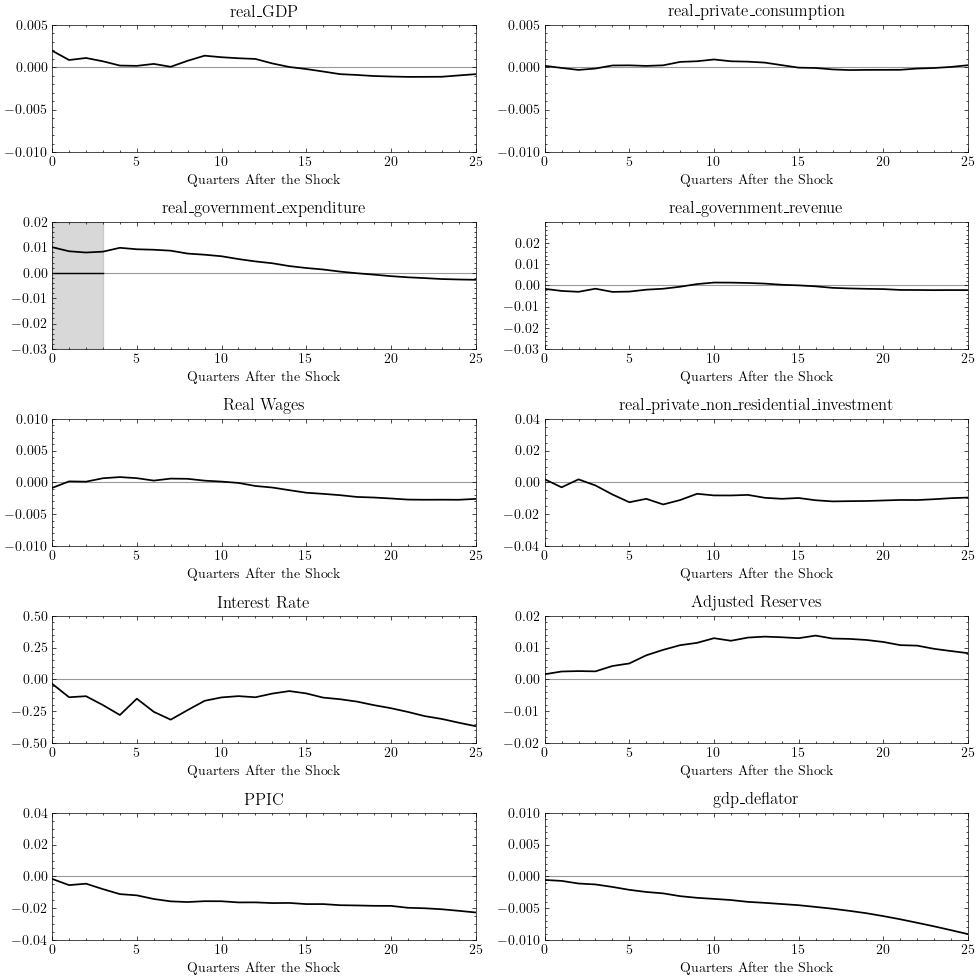

In [25]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_spending[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[1, 0].axvspan(0, 3, color="gray", alpha=0.3)

axes[1, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.03)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.02, -0.01, 0, 0.01, 0.02])
axes[1, 1].set_yticks([-0.03, -0.02, -0.01, 0, 0.01, 0.02])


plt.tight_layout()
plt.savefig("spending.pdf", format="PDF")
plt.show()

### Extension-1 Zero-restriction

#### Define Zero-restriction psi function

In [26]:
def zero_psi(q, positive, negative, periods_start, periods_end):
    positive_part = 0
    negative_part = 0
    if len(positive) > 0:
        for positive_index in positive:
            for period in range(periods_start, periods_end + 1):
                std = np.sqrt(np.diag(sigma)[positive_index])
                inner_part = (
                    get_r_ja(var_res, q=q, horizon=10)[period, positive_index] / std
                )
                positive_part += f(-1 * inner_part)

    if len(negative) > 0:
        for negative_index in negative:
            for period in range(periods_start, periods_end + 1):
                std = np.sqrt(np.diag(sigma)[negative_index])
                inner_part = (
                    get_r_ja(var_res, q=q, horizon=10)[period, negative_index] / std
                )
                negative_part += f(inner_part)
    res = positive_part + negative_part
    return res

#### Zero-restriction for revenue shocks

In [27]:
j = 3
h_zero = 4
R = np.vstack([var_res.irf(10).orth_irfs[k][j, :] for k in range(h_zero + 1)])


norm_constraint = NonlinearConstraint(lambda q: np.sum(q**2), lb=1.0, ub=1.0)

orth_constraint1 = LinearConstraint(q_business_shocks.reshape(1, -1), lb=0.0, ub=0.0)
orth_constraint2 = LinearConstraint(q_monetary_shocks.reshape(1, -1), lb=0.0, ub=0.0)

zero_constraints = [
    LinearConstraint(R[i].reshape(1, -1), lb=0.0, ub=0.0) for i in range(R.shape[0])
]

q0 = get_q(10)


positive = [3]
negative = []
periods_start = 4
periods_end = 7


res = minimize(
    fun=lambda q: zero_psi(q, positive, negative, periods_start, periods_end),
    x0=q0,
    method="trust-constr",
    constraints=[
        norm_constraint,
        orth_constraint1,
        orth_constraint2,
        *zero_constraints,
    ],
    options={"verbose": 2, "maxiter": 1000, "xtol": 1e-12},
)

q_anticipated_revenue_shocks = res.x

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  11   |   0   | -4.7770e-01 | 1.00e+00 | 1.71e-01 | 7.46e-01 |
|   2   |  22   |   1   | -1.0443e+00 | 5.69e+00 | 9.79e-02 | 3.99e-01 |
|   3   |  33   |   2   | -1.0529e+00 | 5.69e+00 | 1.03e+00 | 3.54e-01 |
|   4   |  44   |   3   | -9.2613e-01 | 5.69e+00 | 6.87e+00 | 1.69e-01 |
|   5   |  66   |   5   | -9.2613e-01 | 1.16e+00 | 6.87e+00 | 1.69e-01 |
|   6   |  88   |   6   | -9.2613e-01 | 5.81e-01 | 6.87e+00 | 1.69e-01 |
|   7   |  99   |   8   | -9.2613e-01 | 2.90e-01 | 6.87e+00 | 1.69e-01 |
|   8   |  110  |   9   | -9.2613e-01 | 1.45e-01 | 6.87e+00 | 1.69e-01 |
|   9   |  121  |  10   | -8.2466e-01 | 1.45e-01 | 8.85e+00 | 2.11e-02 |
|  10   |  143  |  12   | -8.2466e-01 | 7.26e-02 | 8.85e+00 | 2.11e-02 |
|  11   |  154  |  13   | -8.2466e-01 | 3.63e-02 | 8.85e+00 | 2.11e-02 |
|  12   |  165  |  14   | -8.2466e-01 | 1.81e-02 | 

d:\Miniforge3\envs\py314\Lib\site-packages\scipy\optimize\_differentiable_functions.py:737: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|  35   |  594  |  37   | -8.1028e-01 | 1.73e-08 | 9.09e+00 | 8.44e-15 |
|  36   |  616  |  38   | -8.1028e-01 | 8.65e-09 | 9.09e+00 | 8.44e-15 |
|  37   |  638  |  39   | -8.1028e-01 | 4.33e-09 | 9.09e+00 | 8.44e-15 |
|  38   |  660  |  40   | -8.1028e-01 | 2.16e-09 | 9.09e+00 | 8.44e-15 |
|  39   |  682  |  41   | -8.1028e-01 | 1.08e-09 | 9.09e+00 | 8.44e-15 |
|  40   |  704  |  42   | -8.1028e-01 | 5.41e-10 | 9.09e+00 | 8.44e-15 |
|  41   |  726  |  43   | -8.1028e-01 | 2.70e-10 | 9.09e+00 | 8.44e-15 |
|  42   |  748  |  44   | -8.1028e-01 | 1.35e-10 | 9.09e+00 | 8.44e-15 |
|  43   |  770  |  45   | -8.1028e-01 | 6.76e-11 | 9.09e+00 | 8.44e-15 |
|  44   |  792  |  46   | -8.1028e-01 | 3.38e-11 | 9.09e+00 | 8.44e-15 |
|  45   |  814  |  47   | -8.1028e-01 | 1.69e-11 | 9.09e+00 | 8.44e-15 |
|  46   |  836  |  48   | -8.1028e-01 | 8.45e-12 | 9.09e+00 | 8.44e-15 |
|  47   |  858  |  49   | -8.1028e-01 | 4.22e-12 | 9.09e+00 | 8.44e-15 |
|  48   |  880  |  50   | -8.1028e-01 | 2.11e-12 | 

In [28]:
r_anticipated_revenue = get_r_ja(var_res, q_anticipated_revenue_shocks, 25)
print(r_anticipated_revenue.shape)

(26, 10)


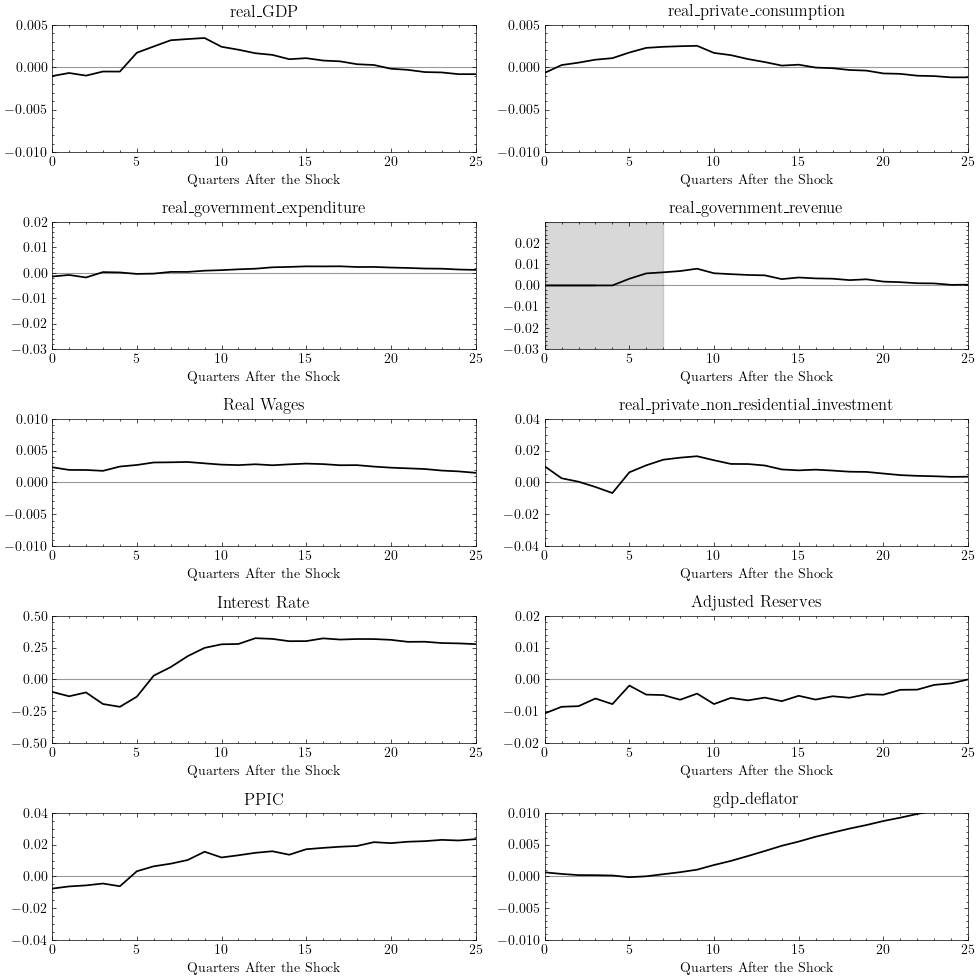

In [29]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_anticipated_revenue[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[1, 1].axvspan(0, 7, color="gray", alpha=0.3)

axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.03)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.02, -0.01, 0, 0.01, 0.02])
axes[1, 1].set_yticks([-0.03, -0.02, -0.01, 0, 0.01, 0.02])


plt.tight_layout()
plt.savefig("anticipated_revenue.pdf", format="PDF")
plt.show()

#### Zero-restriction for spending shocks

In [30]:
j = 2
h_zero = 4
R = np.vstack([var_res.irf(10).orth_irfs[k][j, :] for k in range(h_zero + 1)])

norm_constraint = NonlinearConstraint(lambda q: np.sum(q**2), lb=1.0, ub=1.0)

orth_constraint1 = LinearConstraint(q_business_shocks.reshape(1, -1), lb=0.0, ub=0.0)
orth_constraint2 = LinearConstraint(q_monetary_shocks.reshape(1, -1), lb=0.0, ub=0.0)

zero_constraints = [
    LinearConstraint(R[i].reshape(1, -1), lb=0.0, ub=0.0) for i in range(R.shape[0])
]

q0 = get_q(10)


positive = [2]
negative = []
periods_start = 5
periods_end = 8


res = minimize(
    fun=lambda q: zero_psi(q, positive, negative, periods_start, periods_end),
    x0=q0,
    method="trust-constr",
    constraints=[
        norm_constraint,
        orth_constraint1,
        orth_constraint2,
        *zero_constraints,
    ],
    options={"verbose": 2, "maxiter": 1000, "xtol": 1e-12, "gtol": 1e-12},
)

q_anticipated_spending_shocks = res.x

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  11   |   0   | -1.8548e+00 | 1.00e+00 | 8.71e-01 | 4.89e-01 |
|   2   |  22   |   1   | -2.6319e+00 | 6.99e+00 | 6.18e-01 | 7.97e-01 |
|   3   |  33   |   2   | -2.6319e+00 | 6.99e-01 | 6.18e-01 | 7.97e-01 |
|   4   |  44   |   3   | -2.6319e+00 | 3.49e-01 | 6.18e-01 | 7.97e-01 |
|   5   |  55   |   4   | -2.2400e+00 | 2.45e+00 | 3.72e-01 | 1.74e-01 |
|   6   |  66   |   5   | -2.2400e+00 | 2.45e-01 | 3.72e-01 | 1.74e-01 |
|   7   |  77   |   6   | -1.9182e+00 | 1.71e+00 | 1.86e-01 | 5.87e-02 |
|   8   |  88   |   7   | -1.9182e+00 | 1.71e-01 | 1.86e-01 | 5.87e-02 |
|   9   |  99   |   8   | -1.6796e+00 | 3.42e-01 | 6.07e-02 | 2.09e-02 |
|  10   |  110  |   9   | -1.6796e+00 | 6.47e-02 | 6.07e-02 | 2.09e-02 |
|  11   |  121  |  10   | -1.5696e+00 | 4.53e-01 | 1.49e-02 | 9.41e-03 |
|  12   |  132  |  11   | -1.5696e+00 | 4.53e-02 | 

d:\Miniforge3\envs\py314\Lib\site-packages\scipy\optimize\_differentiable_functions.py:737: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|  39   |  451  |  39   | -1.3816e+00 | 6.49e-05 | 7.61e-09 | 4.34e-19 |
|  40   |  462  |  40   | -1.3816e+00 | 6.49e-06 | 7.61e-09 | 4.34e-19 |
|  41   |  462  |  41   | -1.3816e+00 | 6.49e-07 | 7.61e-09 | 4.34e-19 |
|  42   |  462  |  42   | -1.3816e+00 | 6.49e-08 | 7.61e-09 | 4.34e-19 |
|  43   |  462  |  43   | -1.3816e+00 | 6.49e-09 | 7.61e-09 | 4.34e-19 |
|  44   |  462  |  44   | -1.3816e+00 | 6.49e-10 | 7.61e-09 | 4.34e-19 |
|  45   |  462  |  45   | -1.3816e+00 | 6.49e-11 | 7.61e-09 | 4.34e-19 |
|  46   |  462  |  46   | -1.3816e+00 | 6.49e-12 | 7.61e-09 | 4.34e-19 |
|  47   |  462  |  47   | -1.3816e+00 | 6.49e-13 | 7.61e-09 | 4.34e-19 |

`xtol` termination condition is satisfied.
Number of iterations: 47, function evaluations: 462, CG iterations: 47, optimality: 7.61e-09, constraint violation: 4.34e-19, execution time:  3.7 s.


In [31]:
r_anticipated_spending = get_r_ja(var_res, q_anticipated_spending_shocks, 25)
print(r_anticipated_spending.shape)

(26, 10)


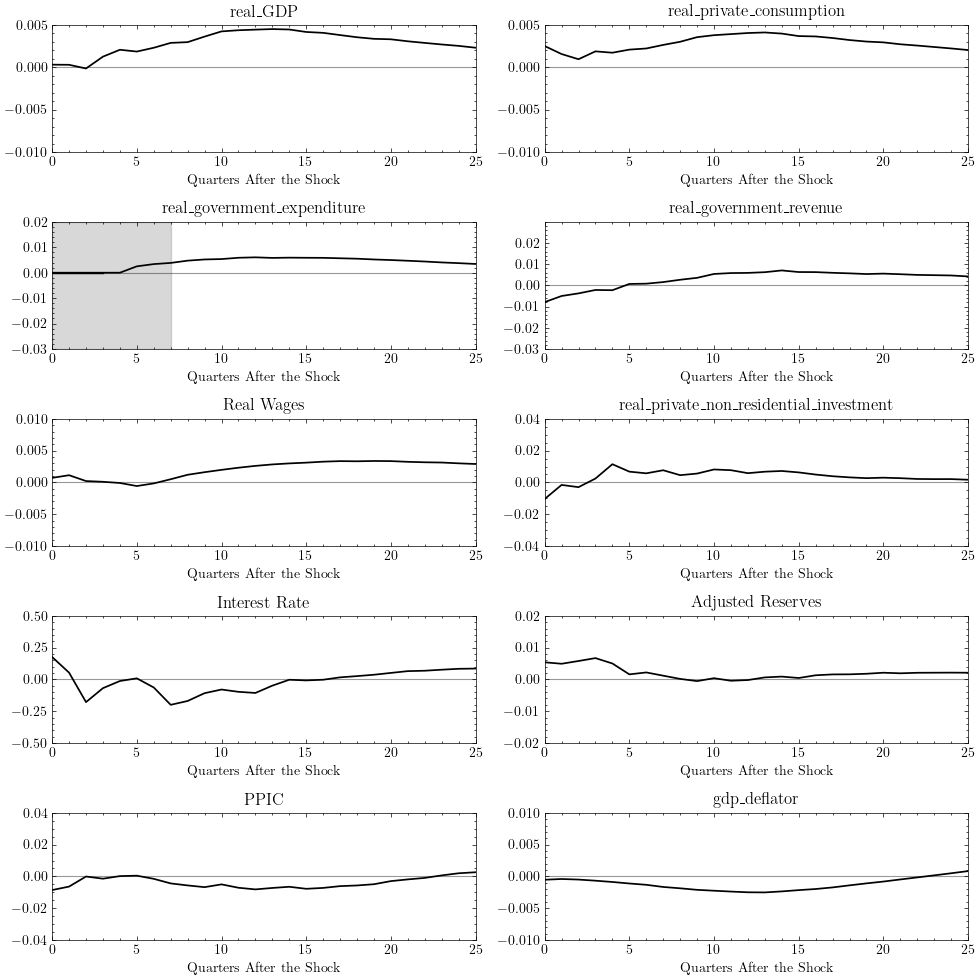

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_anticipated_spending[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[1, 0].axvspan(0, 7, color="gray", alpha=0.3)

axes[1, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.03)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.02, -0.01, 0, 0.01, 0.02])
axes[1, 1].set_yticks([-0.03, -0.02, -0.01, 0, 0.01, 0.02])


plt.tight_layout()
plt.savefig("anticipated_spending.pdf", format="PDF")
plt.show()

#### Extension 2 - Time trend of Shocks

In [33]:
resid = var_res.resid
print(resid.shape)

(178, 10)


In [34]:
q = q_business_shocks / np.sqrt(q_business_shocks.T @ sigma @ q_business_shocks)
eps_biz = resid @ q

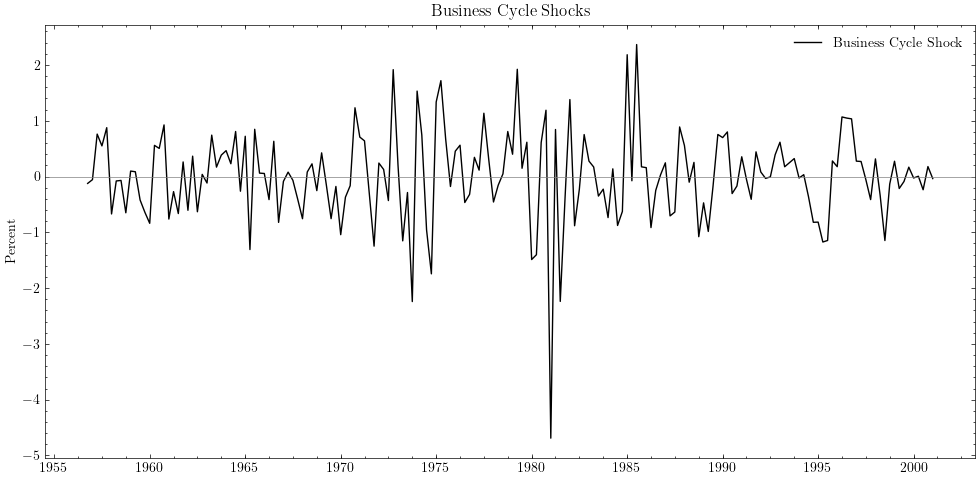

In [35]:
T = resid.shape[0]
dates = pd.date_range(start="1956-10-01", periods=T, freq="QS")
plt.figure(figsize=(10, 5))
plt.plot(dates, eps_biz, label="Business Cycle Shock", color="black")
plt.axhline(0, color="gray", lw=0.5)
# plt.ylim(-0.5,0.5)
plt.ylabel("Percent")
plt.title("Business Cycle Shocks")
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
q = q_monetary_shocks / np.sqrt(q_monetary_shocks.T @ sigma @ q_monetary_shocks)
eps_monetary = resid @ q

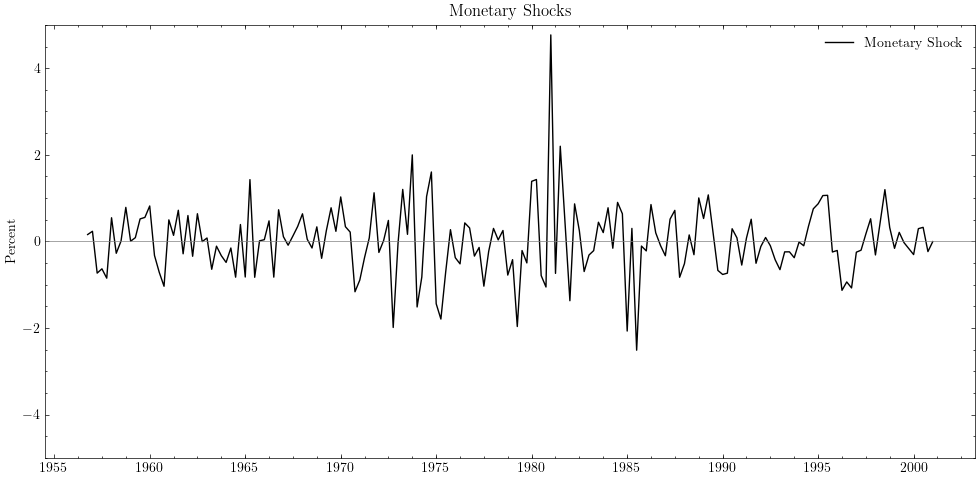

In [37]:
T = resid.shape[0]
dates = pd.date_range(start="1956-10-01", periods=T, freq="QS")
plt.figure(figsize=(10, 5))
plt.plot(dates, eps_monetary, label="Monetary Shock", color="black")
plt.axhline(0, color="gray", lw=0.5)
plt.ylim(-5, 5)
plt.ylabel("Percent")
plt.title("Monetary Shocks")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
q = q_revenue_shocks / np.sqrt(q_revenue_shocks.T @ sigma @ q_revenue_shocks)
eps_revenue = resid @ q


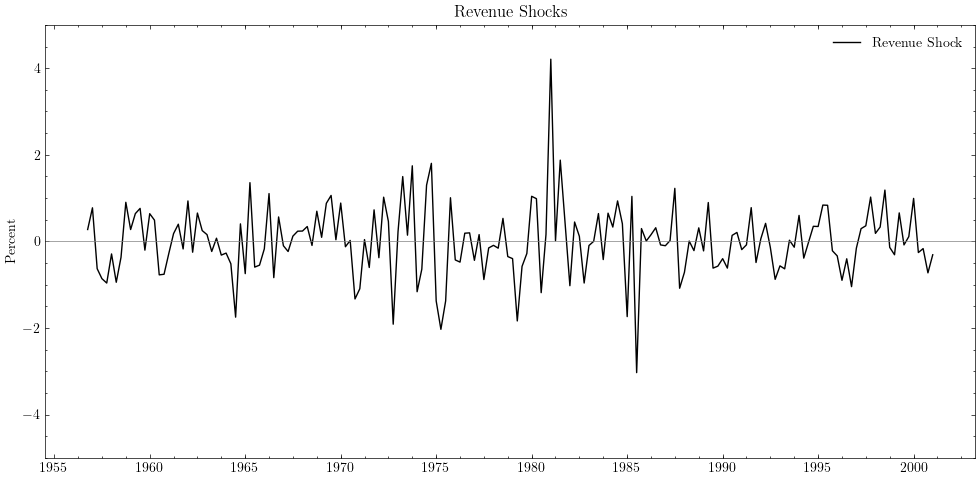

In [39]:
T = resid.shape[0]
dates = pd.date_range(start="1956-10-01", periods=T, freq="QS")
plt.figure(figsize=(10, 5))
plt.plot(dates, eps_revenue, label="Revenue Shock", color="black")
plt.axhline(0, color="gray", lw=0.5)
plt.ylim(-5, 5)
plt.ylabel("Percent")
plt.title("Revenue Shocks")
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
q = q_spending_shocks / np.sqrt(q_spending_shocks.T @ sigma @ q_spending_shocks)
eps_spending = resid @ q

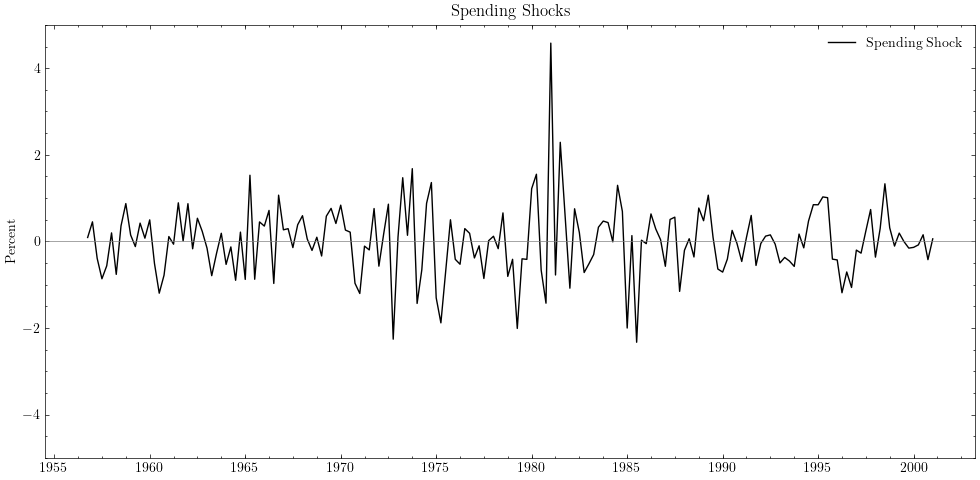

In [41]:
T = resid.shape[0]
dates = pd.date_range(start="1956-10-01", periods=T, freq="QS")
plt.figure(figsize=(10, 5))
plt.plot(dates, eps_spending, label="Spending Shock", color="black")
plt.axhline(0, color="gray", lw=0.5)
plt.ylim(-5, 5)
plt.ylabel("Percent")
plt.title("Spending Shocks")
plt.legend()
plt.tight_layout()
plt.show()

#### Extension 3 - Confidence Interval

In [42]:
lower, upper = var_res.irf_errband_mc(
    orth=True, steps=30, repl=3000, signif=0.32, burn=1500
)

##### Business Cycle Shocks

In [43]:
irf_lower = np.zeros((25 + 1, 10))
irf_upper = np.zeros((25 + 1, 10))

for k in range(25 + 1):
    for i in range(10):
        cholesky_irf_lower = lower[k, i, :]
        cholesky_irf_upper = upper[k, i, :]

        irf_lower[k, i] = np.dot(cholesky_irf_lower, q_business_shocks)
        irf_upper[k, i] = np.dot(cholesky_irf_upper, q_business_shocks)
print(irf_lower.shape, irf_upper.shape)

(26, 10) (26, 10)


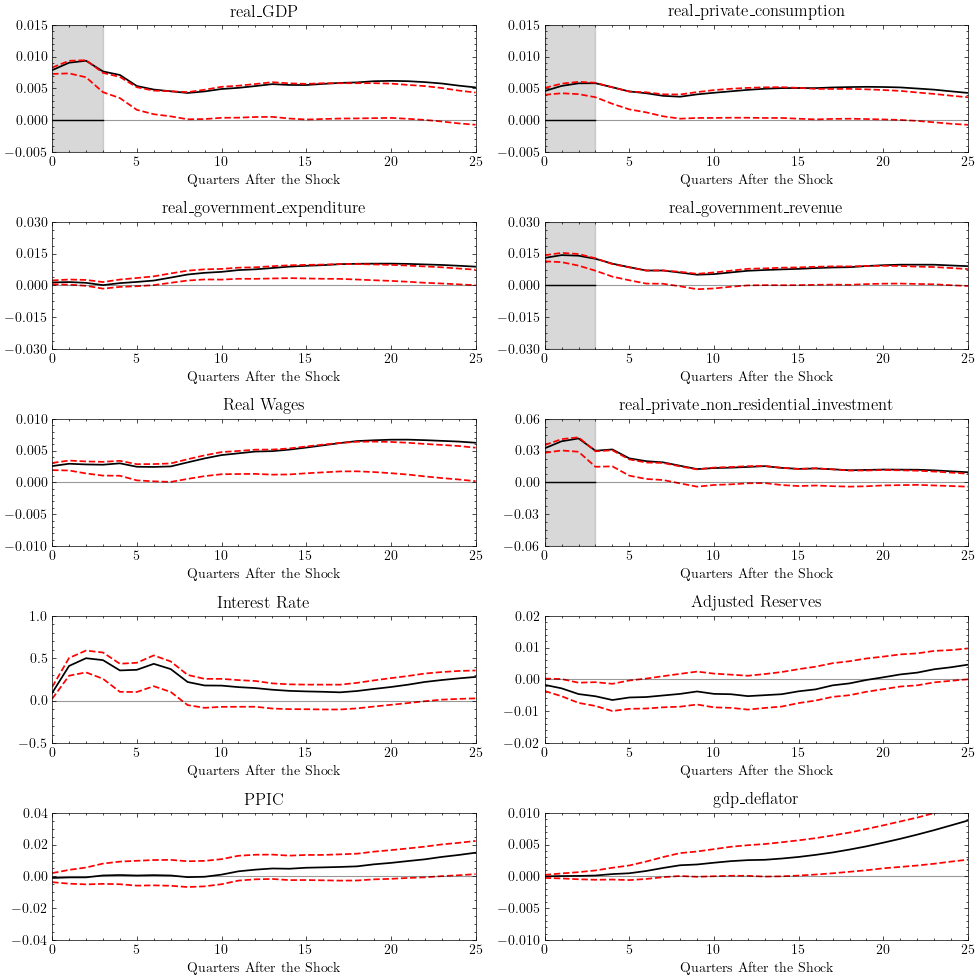

In [44]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_business[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].plot(irf_lower[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].plot(irf_upper[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[0, 0].axvspan(0, 3, color="gray", alpha=0.3)
axes[0, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[1, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[2, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[0, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[0, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[2, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.005, 0.015)
axes[0, 1].set_ylim(-0.005, 0.015)
axes[1, 0].set_ylim(-0.03, 0.03)
axes[1, 1].set_ylim(-0.03, 0.03)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.06, 0.06)
axes[3, 0].set_ylim(-0.5, 1)
axes[3, 1].set_ylim(-0.02, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[1, 1].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[2, 1].set_yticks([-0.06, -0.03, 0, 0.03, 0.06])

plt.tight_layout()
plt.savefig("business_mc.pdf", format="PDF")
plt.show()

##### Monetary Shocks

In [45]:
irf_lower = np.zeros((25 + 1, 10))
irf_upper = np.zeros((25 + 1, 10))

for k in range(25 + 1):
    for i in range(10):
        cholesky_irf_lower = lower[k, i, :]
        cholesky_irf_upper = upper[k, i, :]

        irf_lower[k, i] = np.dot(cholesky_irf_lower, q_monetary_shocks)
        irf_upper[k, i] = np.dot(cholesky_irf_upper, q_monetary_shocks)
print(irf_lower.shape, irf_upper.shape)

(26, 10) (26, 10)


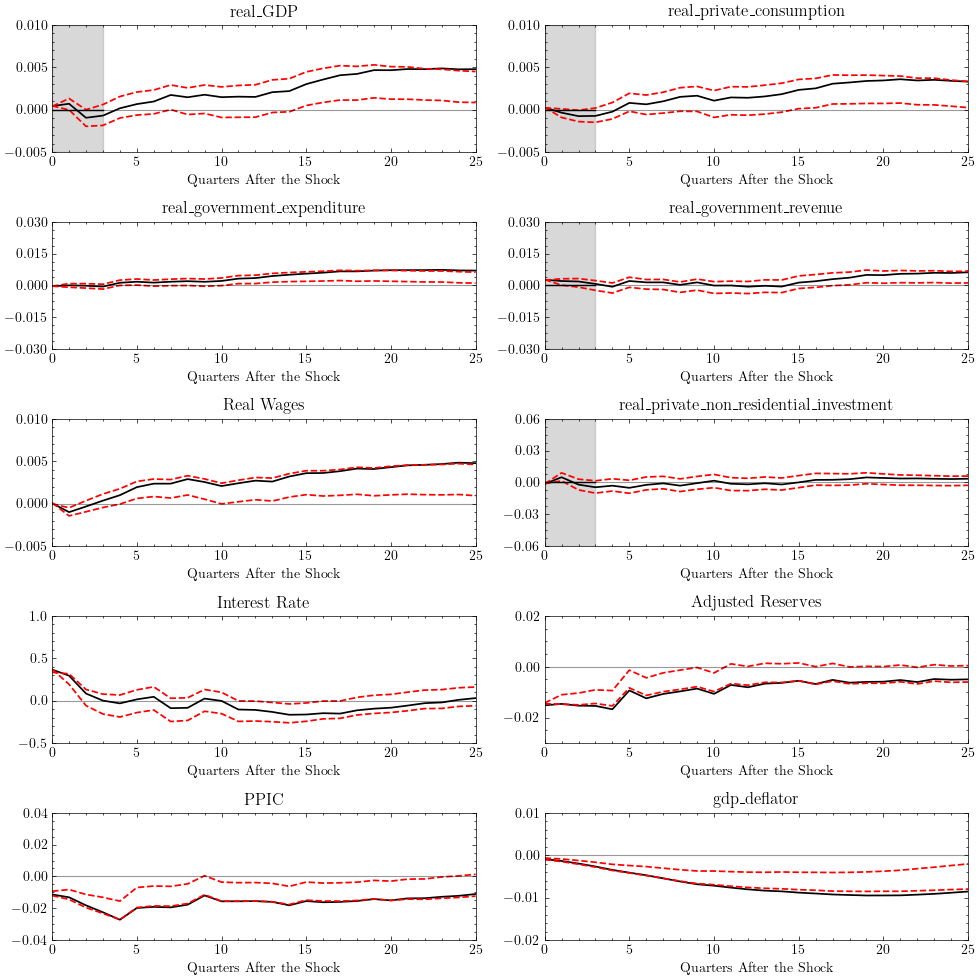

In [46]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_monetary[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].plot(irf_lower[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].plot(irf_upper[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[0, 0].axvspan(0, 3, color="gray", alpha=0.3)
axes[0, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[1, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[2, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[0, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[0, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[2, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.005, 0.01)
axes[0, 1].set_ylim(-0.005, 0.01)
axes[1, 0].set_ylim(-0.02, 0.02)
axes[1, 1].set_ylim(-0.02, 0.03)
axes[2, 0].set_ylim(-0.005, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 1)
axes[3, 1].set_ylim(-0.03, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.02, 0.01)

axes[1, 0].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[1, 1].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[2, 1].set_yticks([-0.06, -0.03, 0, 0.03, 0.06])

plt.tight_layout()
plt.savefig("monetary_mc.pdf", format="PDF")
plt.show()

##### Revenue Shocks

In [47]:
irf_lower = np.zeros((25 + 1, 10))
irf_upper = np.zeros((25 + 1, 10))

for k in range(25 + 1):
    for i in range(10):
        cholesky_irf_lower = lower[k, i, :]
        cholesky_irf_upper = upper[k, i, :]

        irf_lower[k, i] = np.dot(cholesky_irf_lower, q_revenue_shocks)
        irf_upper[k, i] = np.dot(cholesky_irf_upper, q_revenue_shocks)
print(irf_lower.shape, irf_upper.shape)

(26, 10) (26, 10)


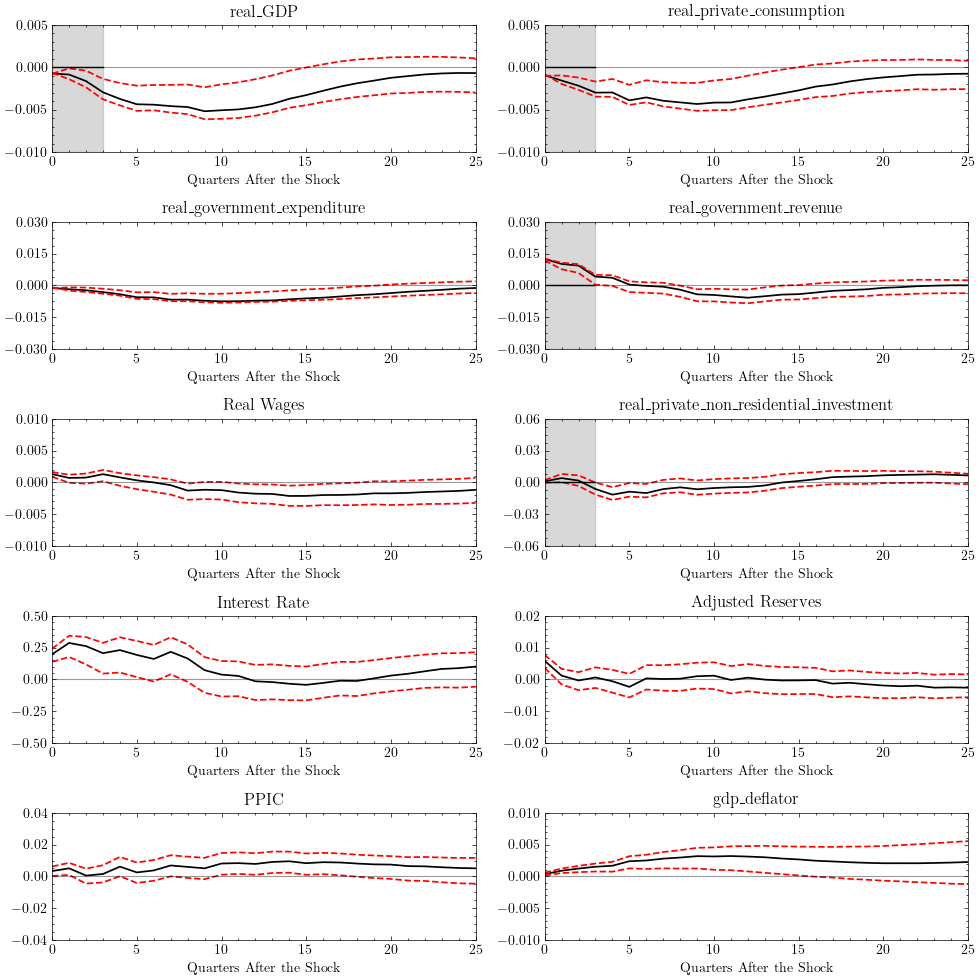

In [48]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_revenue[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].plot(irf_lower[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].plot(irf_upper[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[0, 0].axvspan(0, 3, color="gray", alpha=0.3)
axes[0, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[1, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[2, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[0, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[0, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[2, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.02)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[1, 1].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[2, 1].set_yticks([-0.06, -0.03, 0, 0.03, 0.06])

plt.tight_layout()
plt.savefig("revenue_mc.pdf", format="PDF")
plt.show()

##### Spending Shocks

In [49]:
irf_lower = np.zeros((25 + 1, 10))
irf_upper = np.zeros((25 + 1, 10))

for k in range(25 + 1):
    for i in range(10):
        cholesky_irf_lower = lower[k, i, :]
        cholesky_irf_upper = upper[k, i, :]

        irf_lower[k, i] = np.dot(cholesky_irf_lower, q_spending_shocks)
        irf_upper[k, i] = np.dot(cholesky_irf_upper, q_spending_shocks)
print(irf_lower.shape, irf_upper.shape)

(26, 10) (26, 10)


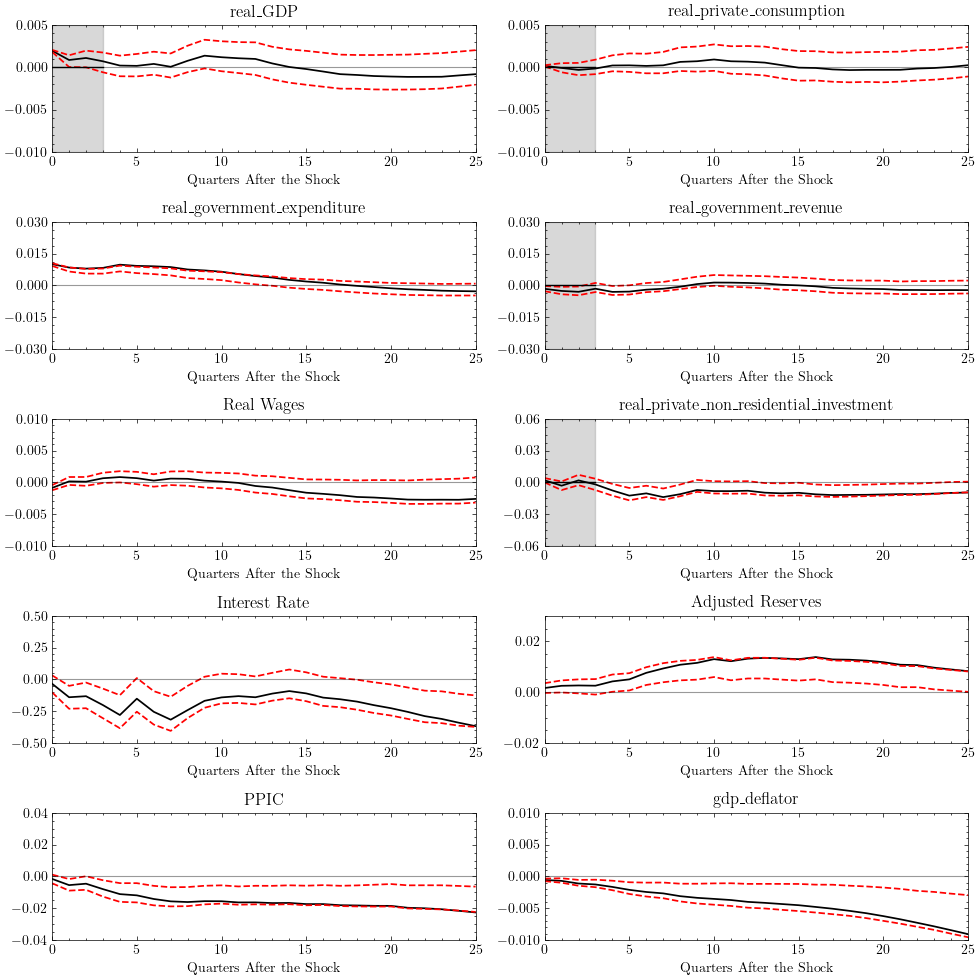

In [50]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_spending[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].plot(irf_lower[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].plot(irf_upper[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[0, 0].axvspan(0, 3, color="gray", alpha=0.3)
axes[0, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[1, 1].axvspan(0, 3, color="gray", alpha=0.3)
axes[2, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[0, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[0, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[2, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.02)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.03)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[1, 1].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[2, 1].set_yticks([-0.06, -0.03, 0, 0.03, 0.06])

plt.tight_layout()
plt.savefig("spending_mc.pdf", format="PDF")
plt.show()

##### Zero-Restriction Revenue Shocks

In [51]:
irf_lower = np.zeros((25 + 1, 10))
irf_upper = np.zeros((25 + 1, 10))

for k in range(25 + 1):
    for i in range(10):
        cholesky_irf_lower = lower[k, i, :]
        cholesky_irf_upper = upper[k, i, :]

        irf_lower[k, i] = np.dot(cholesky_irf_lower, q_anticipated_revenue_shocks)
        irf_upper[k, i] = np.dot(cholesky_irf_upper, q_anticipated_revenue_shocks)
print(irf_lower.shape, irf_upper.shape)

(26, 10) (26, 10)


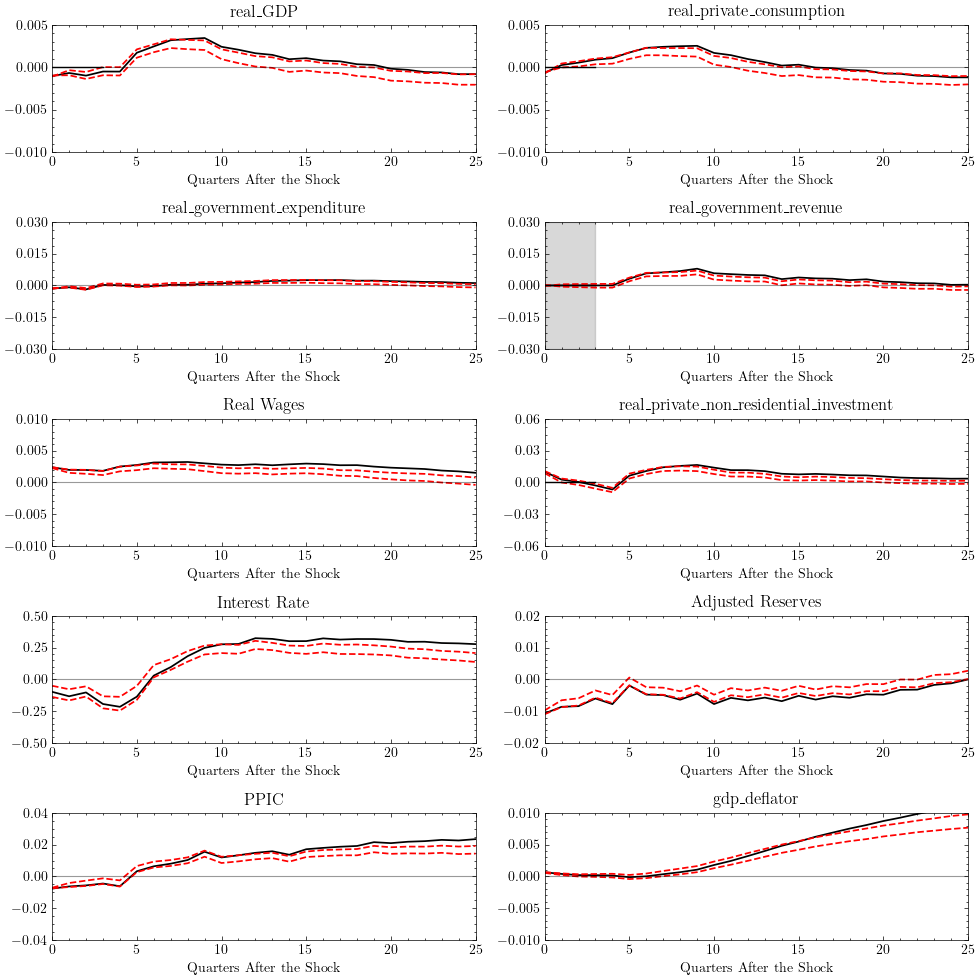

In [52]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_anticipated_revenue[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].plot(irf_lower[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].plot(irf_upper[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[1, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[0, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[0, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[2, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.02)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.02)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[1, 1].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[2, 1].set_yticks([-0.06, -0.03, 0, 0.03, 0.06])

plt.tight_layout()
plt.savefig("anticipated_spending_mc.pdf", format="PDF")
plt.show()

##### Zero-Restriction Spending Shocks

In [53]:
irf_lower = np.zeros((25 + 1, 10))
irf_upper = np.zeros((25 + 1, 10))

for k in range(25 + 1):
    for i in range(10):
        cholesky_irf_lower = lower[k, i, :]
        cholesky_irf_upper = upper[k, i, :]

        irf_lower[k, i] = np.dot(cholesky_irf_lower, q_anticipated_spending_shocks)
        irf_upper[k, i] = np.dot(cholesky_irf_upper, q_anticipated_spending_shocks)
print(irf_lower.shape, irf_upper.shape)

(26, 10) (26, 10)


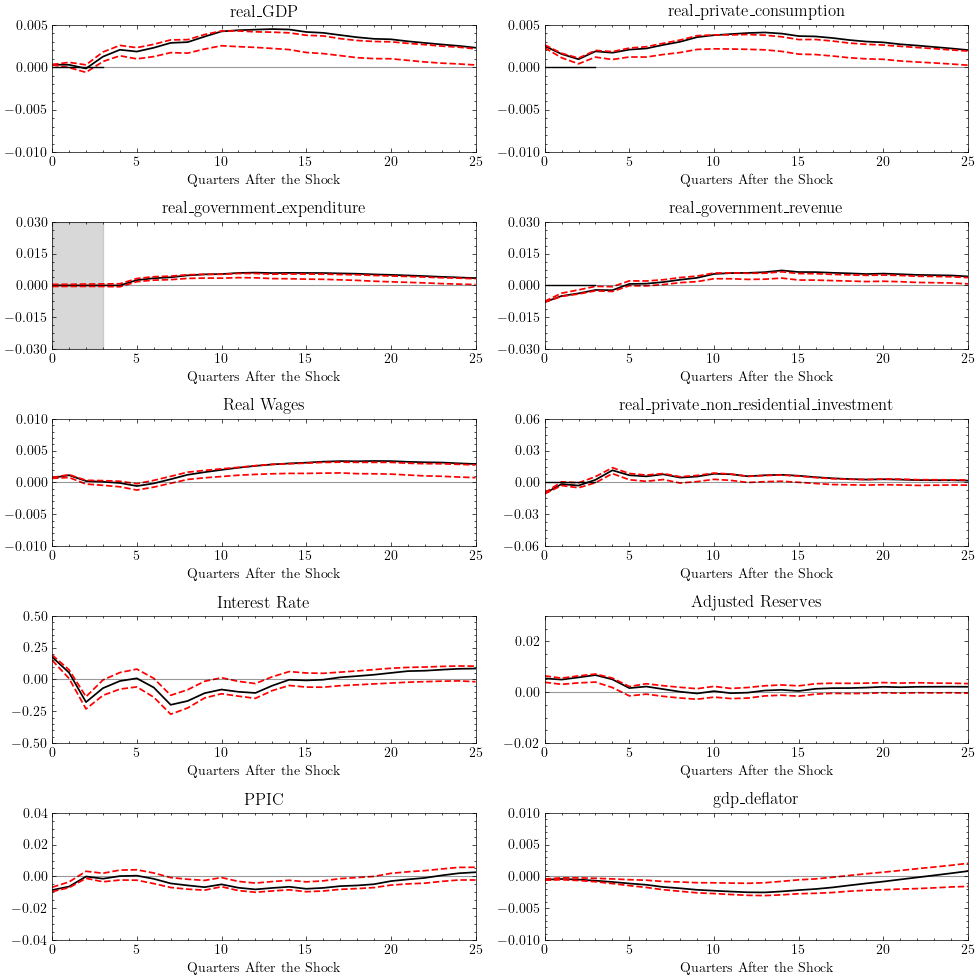

In [54]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(r_anticipated_spending[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].plot(irf_lower[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].plot(irf_upper[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[1, 0].axvspan(0, 3, color="gray", alpha=0.3)


axes[0, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[0, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[2, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.02)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.03)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[1, 1].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[2, 1].set_yticks([-0.06, -0.03, 0, 0.03, 0.06])

plt.tight_layout()
plt.savefig("anticipated_spending_mc.pdf", format="PDF")
plt.show()

#### Extention 4 - Policy Analysis

In [55]:
cashe = get_r_ja(var_res, q_revenue_shocks, 4)
gov_spending_by_revenue = cashe[:4, 2]
gov_revenue_by_revenue = cashe[:4, 3]
print(gov_spending_by_revenue)

[-0.00121245 -0.00178687 -0.00228589 -0.00314774]


In [56]:
cashe = get_r_ja(var_res, q_spending_shocks, 4)
gov_spending_by_spending = cashe[:4, 2]
gov_revenue_by_spending = cashe[:4, 3]
print(gov_spending_by_spending)

[0.01004212 0.008436   0.00794208 0.00828438]


In [57]:
A_spending_gs = np.array(
    [
        [gov_spending_by_spending[0], 0, 0, 0],
        [gov_spending_by_spending[1], gov_spending_by_spending[0], 0, 0],
        [
            gov_spending_by_spending[2],
            gov_spending_by_spending[1],
            gov_spending_by_spending[0],
            0,
        ],
        [
            gov_spending_by_spending[3],
            gov_spending_by_spending[2],
            gov_spending_by_spending[1],
            gov_spending_by_spending[0],
        ],
    ]
)

A_spending_gr = np.array(
    [
        [gov_spending_by_revenue[0], 0, 0, 0],
        [gov_spending_by_revenue[1], gov_spending_by_revenue[0], 0, 0],
        [
            gov_spending_by_revenue[2],
            gov_spending_by_revenue[1],
            gov_spending_by_revenue[0],
            0,
        ],
        [
            gov_spending_by_revenue[3],
            gov_spending_by_revenue[2],
            gov_spending_by_revenue[1],
            gov_spending_by_revenue[0],
        ],
    ]
)

A_revenue_gs = np.array(
    [
        [gov_revenue_by_spending[0], 0, 0, 0],
        [gov_revenue_by_spending[1], gov_revenue_by_spending[0], 0, 0],
        [
            gov_revenue_by_spending[2],
            gov_revenue_by_spending[1],
            gov_revenue_by_spending[0],
            0,
        ],
        [
            gov_revenue_by_spending[3],
            gov_revenue_by_spending[2],
            gov_revenue_by_spending[1],
            gov_revenue_by_spending[0],
        ],
    ]
)

A_revenue_gr = np.array(
    [
        [gov_revenue_by_revenue[0], 0, 0, 0],
        [gov_revenue_by_revenue[1], gov_revenue_by_revenue[0], 0, 0],
        [
            gov_revenue_by_revenue[2],
            gov_revenue_by_revenue[1],
            gov_revenue_by_revenue[0],
            0,
        ],
        [
            gov_revenue_by_revenue[3],
            gov_revenue_by_revenue[2],
            gov_revenue_by_revenue[1],
            gov_revenue_by_revenue[0],
        ],
    ]
)


A_full_8d = np.block([[A_spending_gs, A_spending_gr], [A_revenue_gs, A_revenue_gr]])

b_8d = np.concatenate([np.full(4, 0.01), np.zeros(4)])

solution_8d = np.linalg.solve(A_full_8d, b_8d)

shock_labels_8d = [f"BGS_{i}" for i in range(4)] + [f"BGR_{i}" for i in range(4)]
solution_8d_series = pd.Series(solution_8d, index=shock_labels_8d)
solution_8d_series

BGS_0    1.011555
BGS_1    0.184793
BGS_2    0.104499
BGS_3    0.011569
BGR_0    0.130440
BGR_1    0.128757
BGR_2    0.093945
BGR_3   -0.022526
dtype: float64

In [58]:
irfs_revenue = get_r_ja(var_res, q_revenue_shocks, 30)
irfs_spending = get_r_ja(var_res, q_spending_shocks, 30)

BGS_j = solution_8d_series.iloc[:4].values
BGR_j = solution_8d_series.iloc[4:].values

BGS_extended = np.zeros(30)
BGS_extended[:4] = BGS_j

BGR_extended = np.zeros(30)
BGR_extended[:4] = BGR_j

response_spending = np.zeros((30, 10))
response_revenue = np.zeros((30, 10))

for k in range(30):
    for j in range(k + 1):
        response_spending[k] += BGS_extended[j] * irfs_spending[k - j]
        response_revenue[k] += BGR_extended[j] * irfs_revenue[k - j]

response_total = response_spending + response_revenue

In [59]:
irf_revenue_lower = np.zeros((30, 10))
irf_revenue_upper = np.zeros((30, 10))
irf_spending_lower = np.zeros((30, 10))
irf_spending_upper = np.zeros((30, 10))


for k in range(30):
    for i in range(10):
        cholesky_irf_lower = lower[k, i, :]
        cholesky_irf_upper = upper[k, i, :]

        irf_revenue_lower[k, i] = np.dot(cholesky_irf_lower, q_revenue_shocks)
        irf_revenue_upper[k, i] = np.dot(cholesky_irf_upper, q_revenue_shocks)

        irf_spending_lower[k, i] = np.dot(cholesky_irf_lower, q_spending_shocks)
        irf_spending_upper[k, i] = np.dot(cholesky_irf_upper, q_spending_shocks)
print(irf_revenue_lower.shape)

(30, 10)


In [60]:
response_lower = np.zeros((30, 10))
response_upper = np.zeros((30, 10))

for k in range(30):
    for j in range(k + 1):
        response_lower[k] += (
            BGS_extended[j] * irf_spending_lower[k - j]
            + BGR_extended[j] * irf_revenue_lower[k - j]
        )
        response_upper[k] += (
            BGS_extended[j] * irf_spending_upper[k - j]
            + BGR_extended[j] * irf_revenue_upper[k - j]
        )

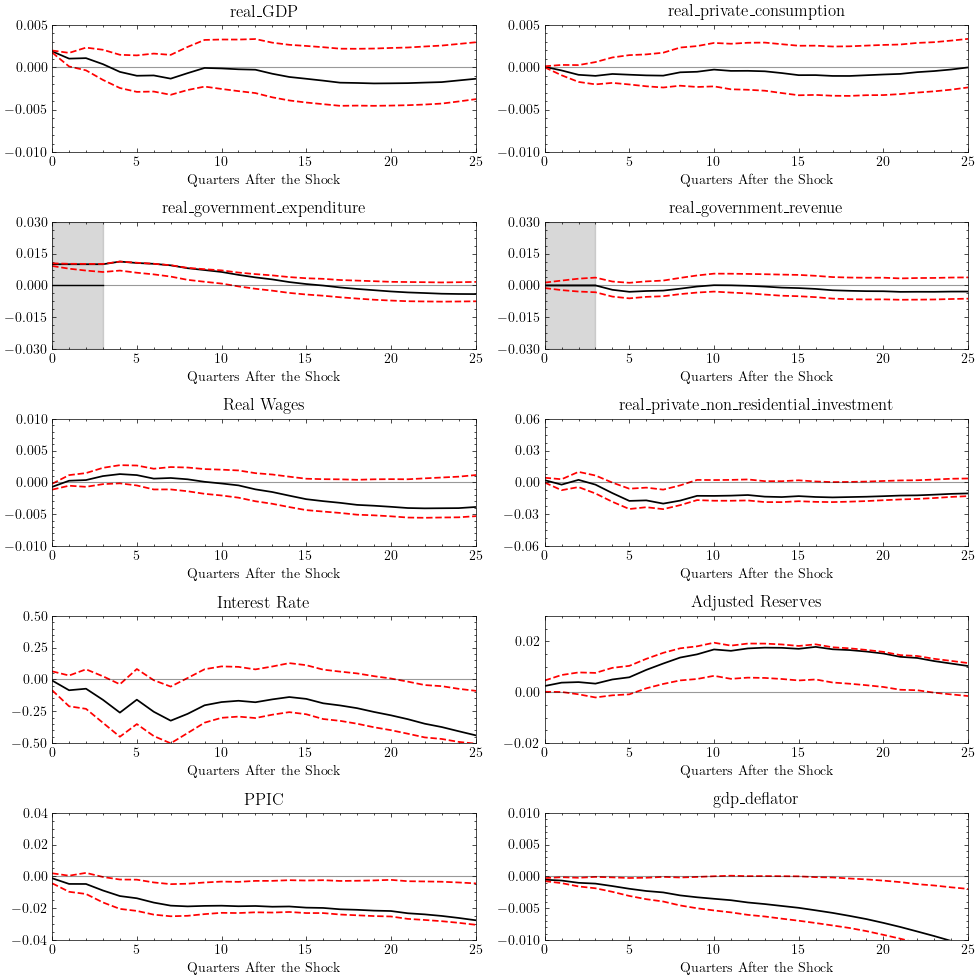

In [61]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        axes[i, j].plot(response_total[:, i * 2 + j], color="black", lw=1.25)
        axes[i, j].plot(response_lower[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].plot(response_upper[:, i * 2 + j], color="red", ls="dashed", lw=1.25)
        axes[i, j].axhline(y=0, color="black", alpha=0.4, lw=0.8)
        axes[i, j].set_xlim(0, 25)
        axes[i, j].set_title(names[i * 2 + j], fontsize=12)
        axes[i, j].set_xlabel("Quarters After the Shock", fontsize=10)

axes[1, 0].axvspan(0, 3, color="gray", alpha=0.3)
axes[1, 1].axvspan(0, 3, color="gray", alpha=0.3)

axes[1, 1].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)
axes[1, 0].axhline(y=0, xmin=0, xmax=0.12, color="black", lw=1)

axes[0, 0].set_ylim(-0.01, 0.005)
axes[0, 1].set_ylim(-0.01, 0.005)
axes[1, 0].set_ylim(-0.03, 0.02)
axes[1, 1].set_ylim(-0.03, 0.02)
axes[2, 0].set_ylim(-0.01, 0.01)
axes[2, 1].set_ylim(-0.04, 0.04)
axes[3, 0].set_ylim(-0.5, 0.5)
axes[3, 1].set_ylim(-0.02, 0.03)
axes[4, 0].set_ylim(-0.04, 0.04)
axes[4, 1].set_ylim(-0.01, 0.01)

axes[1, 0].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[1, 1].set_yticks([-0.03, -0.015, 0, 0.015, 0.03])
axes[2, 1].set_yticks([-0.06, -0.03, 0, 0.03, 0.06])

plt.tight_layout()
plt.savefig("deficit_spending_mc.pdf", format="PDF")
plt.show()